# Azure Anomaly Detector API to Analyze Stock Performance Data

Define Azure Anomaly Detector API Endpoint and Subscription Key

Read detail API documentation : https://westus2.dev.cognitive.microsoft.com/docs/services/AnomalyDetector/operations/post-timeseries-entire-detect

In [1]:
# To start sending requests to the Anomaly Detector API, paste your subscription key you received after creating Anomaly Detector resource. 
subscription_key = 'PLEASE_ENTER_YOUR_OWN_AZURE_ANOMALY_DETECTOR_API_KEY' 

# Use the endpoint your received from overview section of the Anomaly Detector resource you created
# the endpoint is like https://westus2.api.cognitive.microsoft.com/, different by regions, you need to concat anomalydetector/v1.0/timeseries/entire/detect

endpoint = 'https://westus2.api.cognitive.microsoft.com/anomalydetector/v1.0/timeseries/entire/detect'

Import necessary packages

In [2]:
import requests
import json
import pandas as pd
import numpy as np
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
from bokeh.plotting import figure,output_notebook, show
from bokeh.palettes import Blues4
from bokeh.models import ColumnDataSource,Slider
import datetime
from bokeh.io import push_notebook
from dateutil import parser
from ipywidgets import interact, widgets, fixed
output_notebook()

Loading BokehJS ...

Define API call function

In [4]:
def detect(endpoint, subscription_key, request_data):
    headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': subscription_key}
    response = requests.post(endpoint, data=json.dumps(request_data), headers=headers)
    if response.status_code == 200:
        return json.loads(response.content.decode("utf-8"))
    else:
        print(response.status_code)
        raise Exception(response.text)

Define API response handling function

In [5]:
def build_figure(sample_data, sensitivity):
    sample_data['sensitivity'] = sensitivity
    result = detect(endpoint, subscription_key, sample_data)
    columns = {'expectedValues': result['expectedValues'], 'isAnomaly': result['isAnomaly'], 'isNegativeAnomaly': result['isNegativeAnomaly'],
          'isPositiveAnomaly': result['isPositiveAnomaly'], 'upperMargins': result['upperMargins'], 'lowerMargins': result['lowerMargins'],
          'timestamp': [parser.parse(x['timestamp']) for x in sample_data['series']], 
          'value': [x['value'] for x in sample_data['series']]}
    response = pd.DataFrame(data=columns)
    values = response['value']
    label = response['timestamp']
    anomalies = []
    anomaly_labels = []
    index = 0
    anomaly_indexes = []
    p = figure(x_axis_type='datetime', title="Batch Anomaly Detection ({0} Sensitvity)".format(sensitivity), width=800, height=600)
    for anom in response['isAnomaly']:
        if anom == True and (values[index] > response.iloc[index]['expectedValues'] + response.iloc[index]['upperMargins'] or 
                         values[index] < response.iloc[index]['expectedValues'] - response.iloc[index]['lowerMargins']):
            anomalies.append(values[index])
            anomaly_labels.append(label[index])
            anomaly_indexes.append(index)
        index = index+1
    upperband = response['expectedValues'] + response['upperMargins']
    lowerband = response['expectedValues'] -response['lowerMargins']
    band_x = np.append(label, label[::-1])
        #band_x = np.append(label, label[::-1])
    band_y = np.append(lowerband, upperband[::-1])
        #band_y = np.append(lowerband, upperband[::-1])
    boundary = p.patch(band_x, band_y, color=Blues4[2], fill_alpha=0.5, line_width=1, legend='Boundary')
    p.line(label, values, legend='Value', color="#2222aa", line_width=1)
    p.line(label, response['expectedValues'], legend='ExpectedValue',  line_width=1, line_dash="dotdash", line_color='olivedrab')
    anom_source = ColumnDataSource(dict(x=anomaly_labels, y=anomalies))
    anoms = p.circle('x', 'y', size=5, color='tomato', source=anom_source)
    p.legend.border_line_width = 1
    p.legend.background_fill_alpha  = 0.1
    show(p, notebook_handle=True)

Load prepared stock performance data from Aplha Vantage API

In [6]:
import json
stock_data_from_av = json.load(open('stockdatafromav.json'))
print(stock_data_from_av)

{'granularity': 'weekly', 'series': [{'timestamp': '2018-05-11T00:00:00Z', 'value': 98}, {'timestamp': '2018-05-18T00:00:00Z', 'value': 96}, {'timestamp': '2018-05-25T00:00:00Z', 'value': 98}, {'timestamp': '2018-06-01T00:00:00Z', 'value': 101}, {'timestamp': '2018-06-08T00:00:00Z', 'value': 102}, {'timestamp': '2018-06-15T00:00:00Z', 'value': 100}, {'timestamp': '2018-06-22T00:00:00Z', 'value': 100}, {'timestamp': '2018-06-29T00:00:00Z', 'value': 99}, {'timestamp': '2018-07-06T00:00:00Z', 'value': 101}, {'timestamp': '2018-07-13T00:00:00Z', 'value': 105}, {'timestamp': '2018-07-20T00:00:00Z', 'value': 106}, {'timestamp': '2018-07-27T00:00:00Z', 'value': 108}, {'timestamp': '2018-08-03T00:00:00Z', 'value': 108}, {'timestamp': '2018-08-10T00:00:00Z', 'value': 109}, {'timestamp': '2018-08-17T00:00:00Z', 'value': 108}, {'timestamp': '2018-08-24T00:00:00Z', 'value': 108}, {'timestamp': '2018-08-31T00:00:00Z', 'value': 112}, {'timestamp': '2018-09-07T00:00:00Z', 'value': 108}, {'timestamp':

Show Batch Anomaly Detection with 95% sensitivity

In [7]:
# weekly sample
sample_data = json.load(open('stockdatafromav.json'))
sample_data['granularity'] = 'weekly'
# 95 sensitivity
build_figure(sample_data,95)

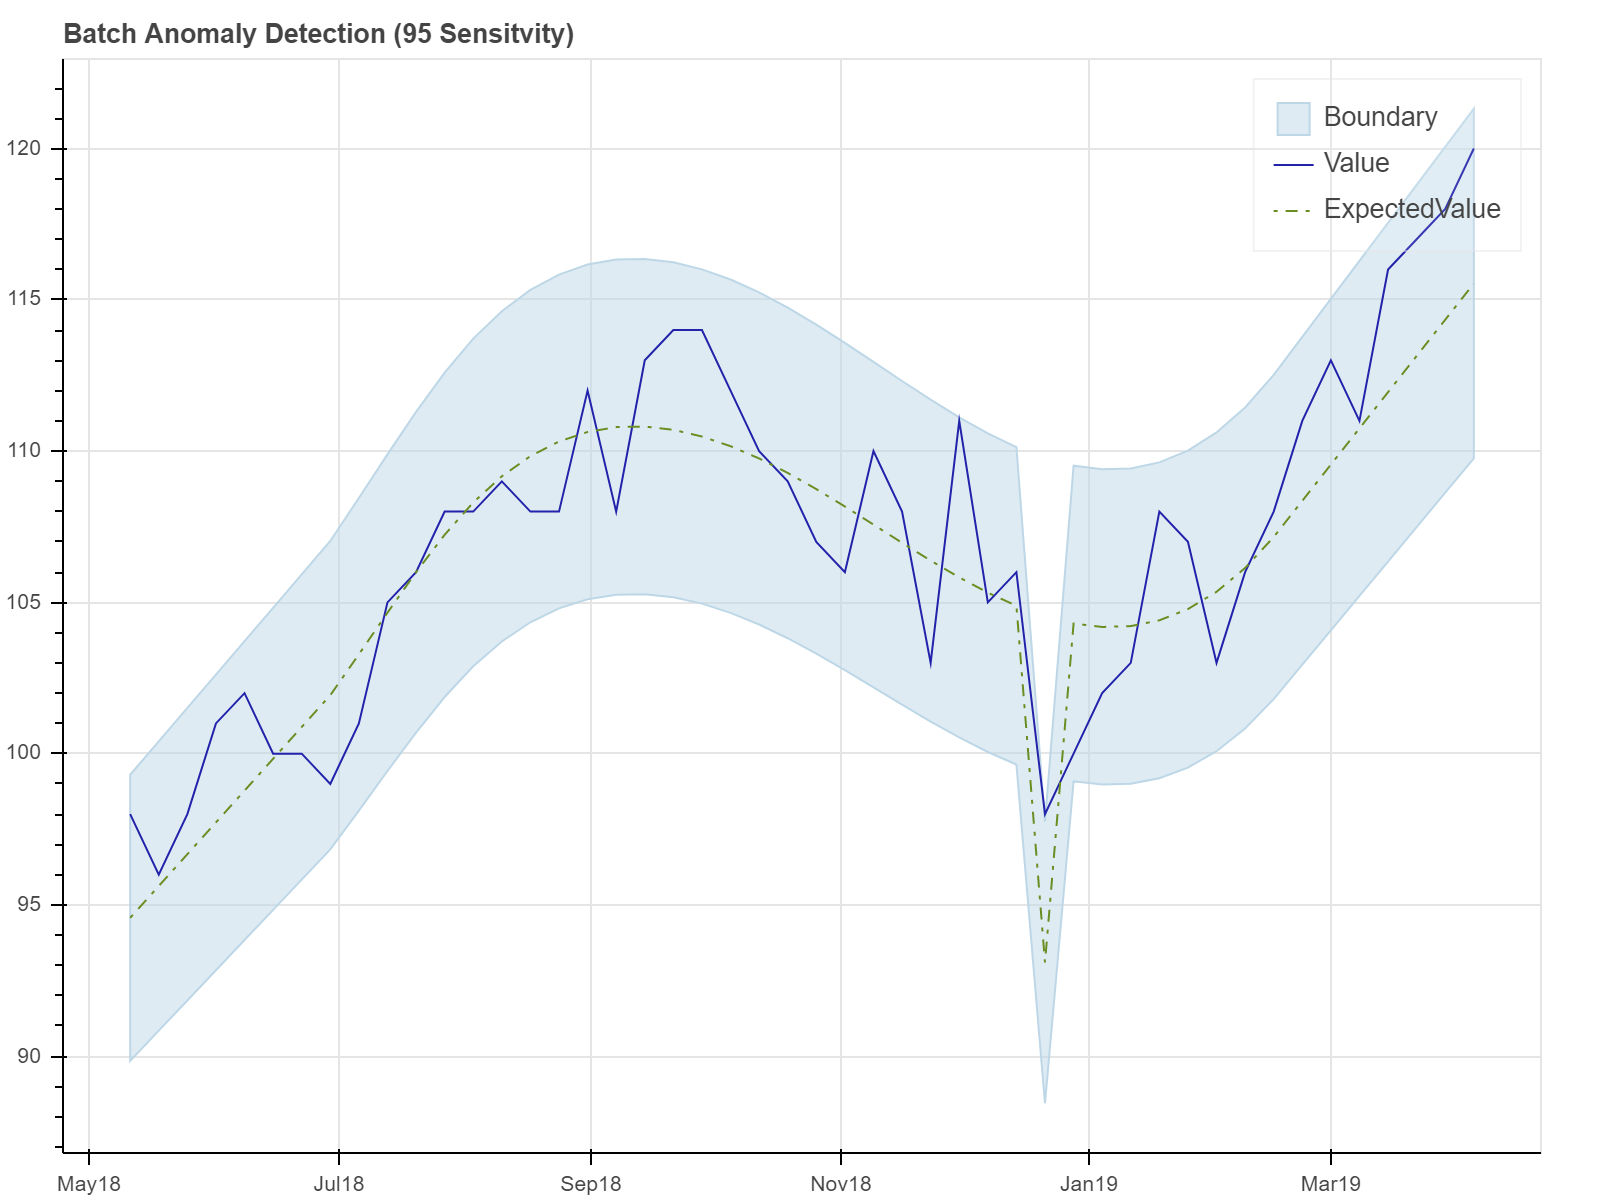

In [3]:
from IPython.display import Image
Image("images/95_sensitivity.png")

Show Batch Anomaly Detection with 90% sensitivity

In [8]:
# weekly sample
sample_data = json.load(open('stockdatafromav.json'))
sample_data['granularity'] = 'weekly'
# 90 sensitivity
build_figure(sample_data,90)

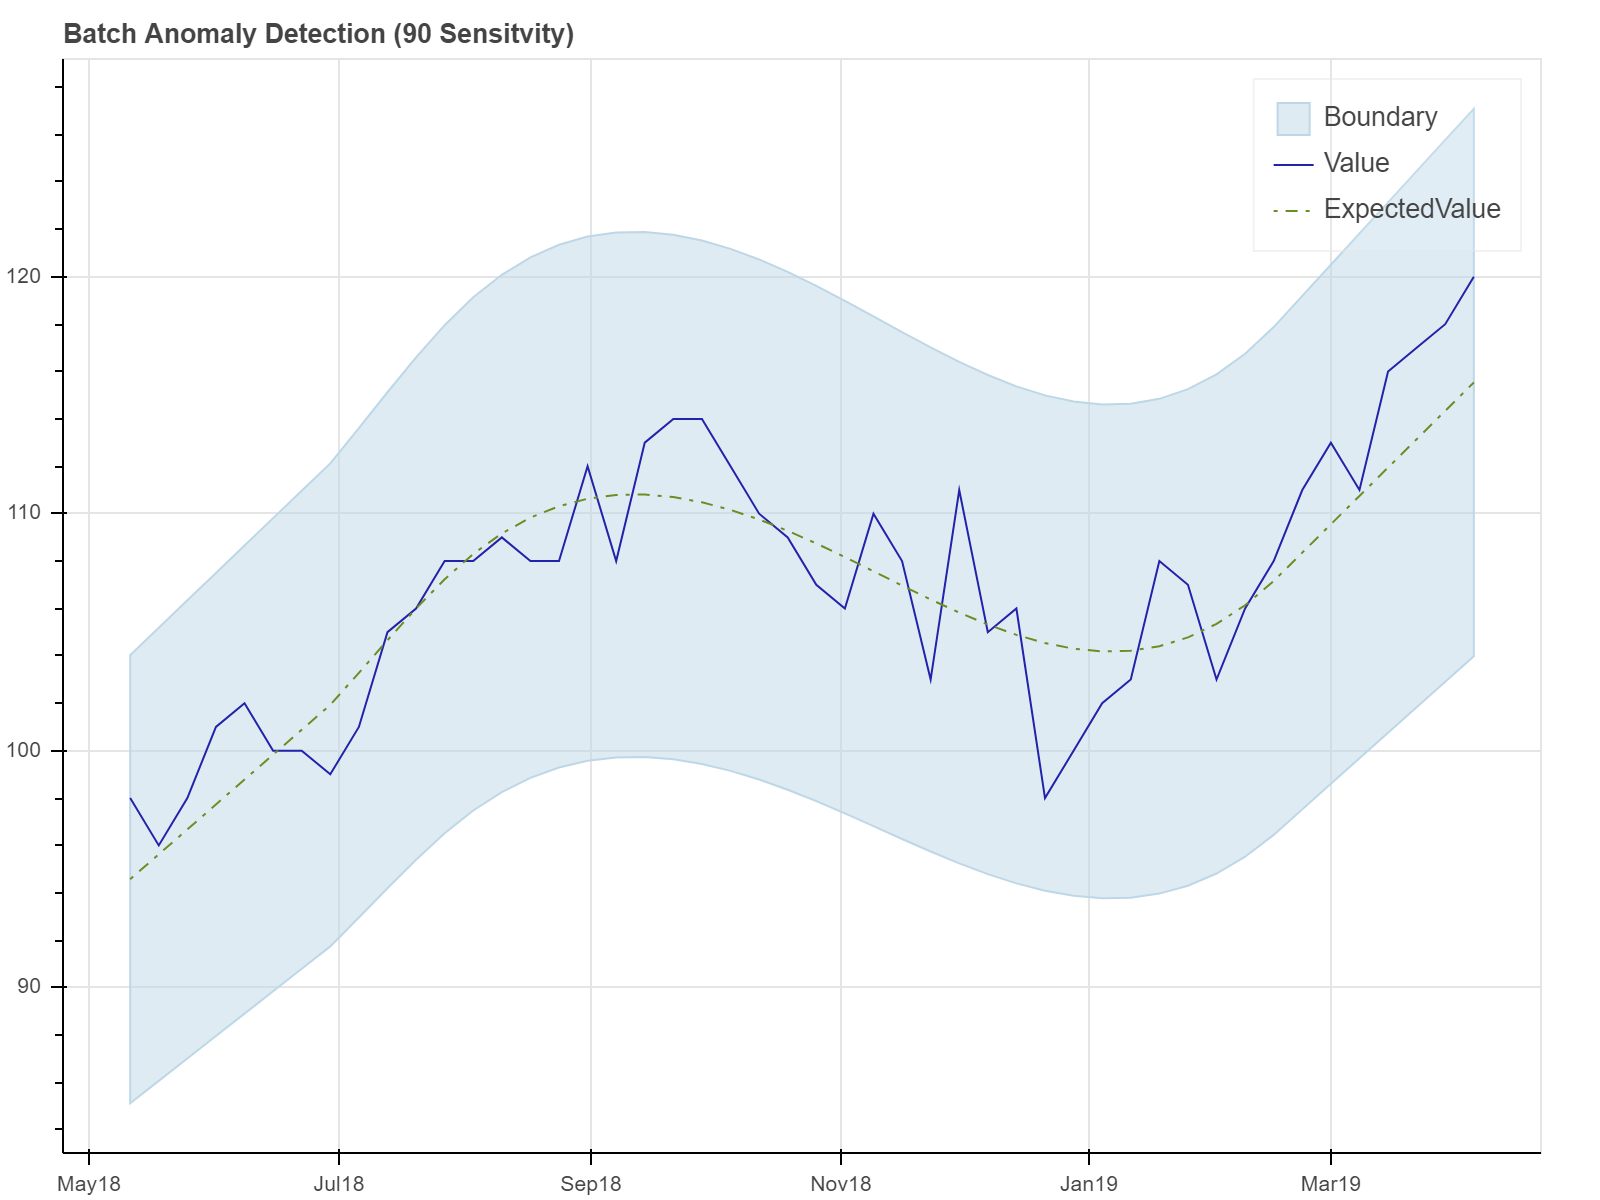

In [2]:
from IPython.display import Image
Image("images/90_sensitivity.png")

Show Batch Anomaly Detection with 95% sensitivity (with modified data to show anomal detection points)

* "timestamp":"2018-07-13T00:00:00Z","value":105 > "timestamp":"2018-07-13T00:00:00Z","value":88
* "timestamp":"2018-09-14T00:00:00Z","value":113 > "timestamp":"2018-09-14T00:00:00Z","value":128

In [9]:
# weekly sample
sample_data = json.load(open('stockdatafromav_modified.json'))
sample_data['granularity'] = 'weekly'
# 95 sensitivity
build_figure(sample_data,95)

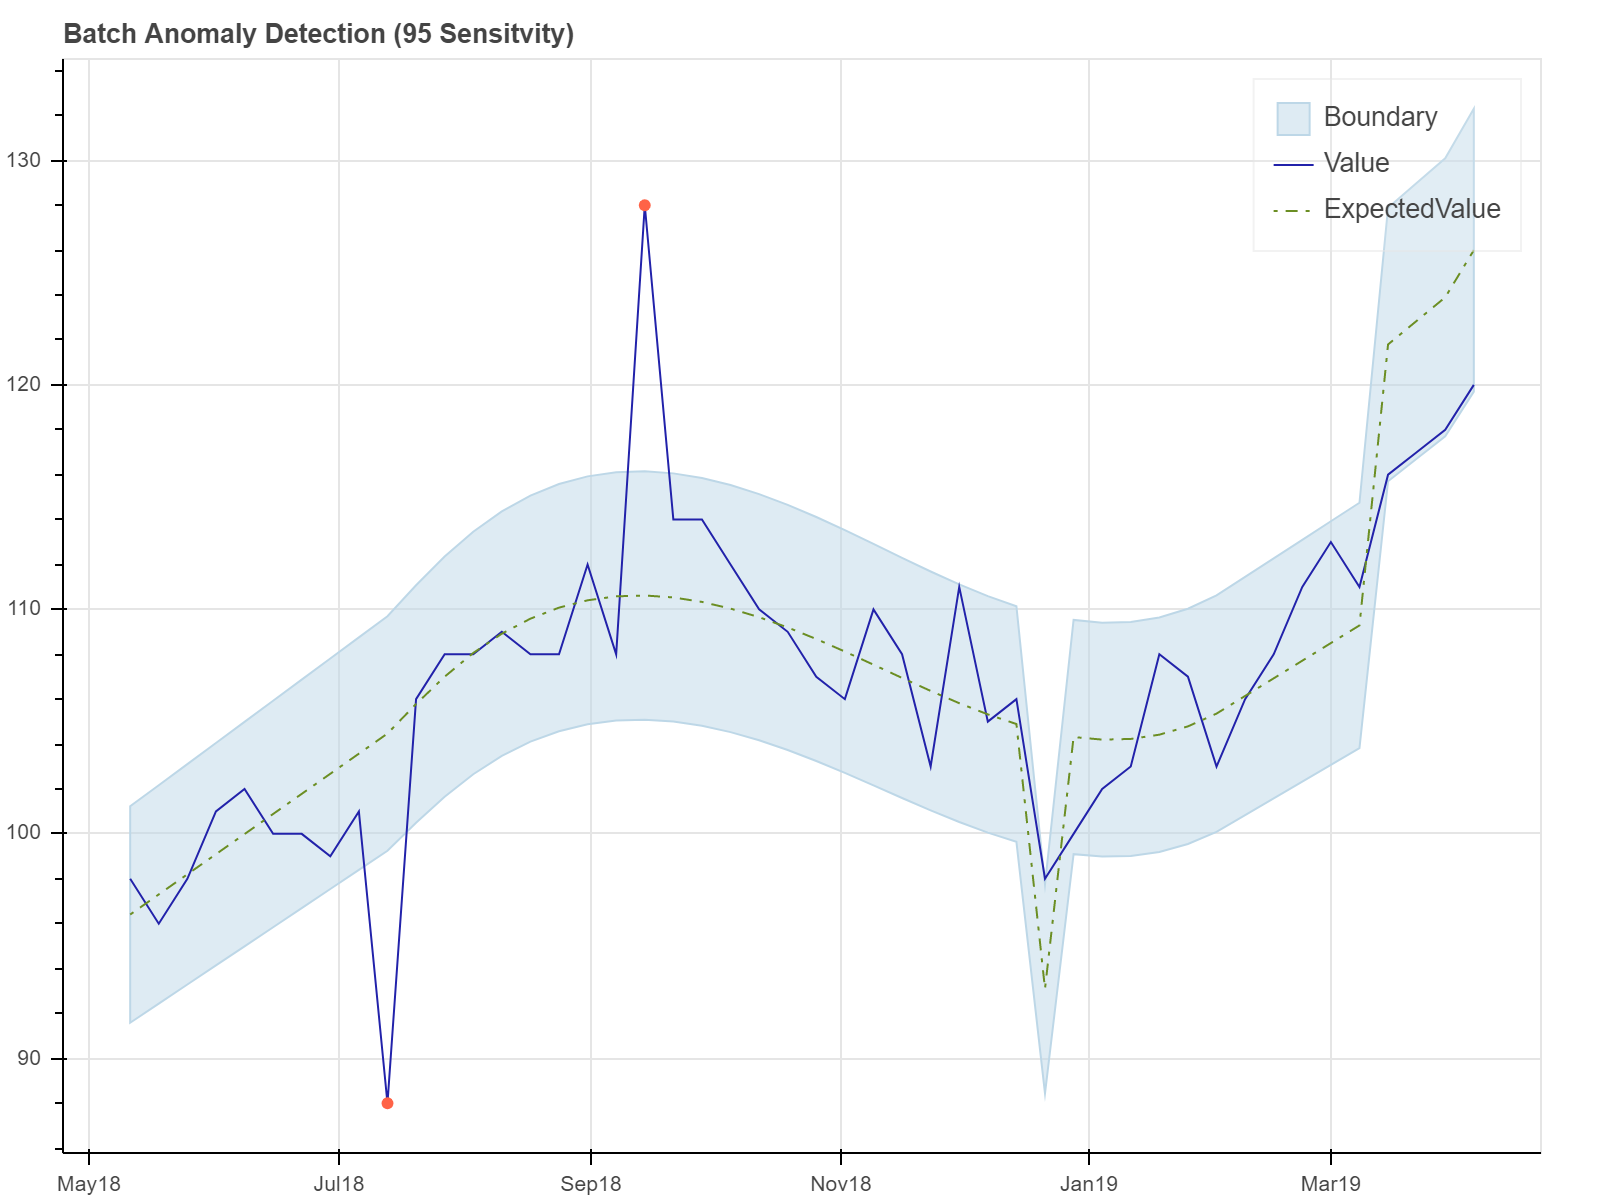

In [1]:
from IPython.display import Image
Image("images/95_sensitivity_with_anomal_points.png")

END